In [1]:
import numpy as np
import scipy as sp
import pandas as pd

from scipy import optimize

%matplotlib inline 
import matplotlib.pyplot as plt

In [53]:
def rndm(a, b, g, size=1):
    """Power-law gen for pdf(x)\propto x^{g-1} for a<=x<=b"""
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)

E0 = 10**15
E1 = 10**18
gamma = -2.5
N= 10000

E = rndm(E0, E1, gamma, N) 
A = 10**12
B = 1.2

def S_ref(A,B,E):
    return (E/A)**(1/B)

S_i_ref=S_ref(A,B,E)
cos_2 = np.random.rand(N)

def S_i(alpha, beta, delta, cos, f):
    cos_ref=np.cos(38*np.pi/180.)**2
    x = cos-cos_ref
    return f*(delta+beta*x+alpha*x**2)

def S_i_fit(cos, alpha, beta, delta,f):
    cos_ref=np.cos(38*np.pi/180.)**2
    x = cos-cos_ref
    return f*(alpha*x**2+beta*x+delta)

b=0.919
a=-1.13
c=1


S=S_i(a,b,c,cos_2,S_i_ref)

In [3]:
data = pd.DataFrame()
data['E'] = E
data['S_ref'] = S_i_ref
data['cos2'] = cos_2
data['S'] = S
data['th'] = np.arccos(np.sqrt(data.cos2))
data['lgE'] = np.log10(data.E)
data['lgS'] = np.log10(data.S)
data['lgS_ref'] = np.log10(data.S_ref)
print(type(data.index))

<class 'pandas.core.indexes.range.RangeIndex'>


/home/noemie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


In [4]:
data = data.sort_values(['lgS'])
data['I'] = 0
bins = np.linspace(0, 1, 11, endpoint = True )
ind = np.digitize(data['cos2'],bins)
groups = data.groupby(ind)
                      

for name, group in groups:
    values = group['lgS'].apply(lambda x: group[group['lgS']>x].count())
    data.loc[group.I.index.tolist(), 'I']= values.I 
    #print(values)
#print(data)   

                 E       S_ref      cos2           S        th        lgE  \
6132  2.326499e+15  639.124978  0.065755   90.397315  1.311472  15.366703   
748   2.403198e+15  656.635989  0.164893  227.088548  1.152646  15.380790   
2718  2.352812e+15  645.143043  0.267580  344.590235  1.027126  15.371587   
341   2.180215e+15  605.456344  0.395609  445.323260  0.890562  15.338499   
1955  2.479911e+15  674.057177  0.416456  515.519183  0.869336  15.394436   
8593  2.324901e+15  638.758970  0.588601  619.007310  0.696327  15.366404   
7298  2.474692e+15  672.874858  0.649821  690.087824  0.633239  15.393521   
6583  2.389138e+15  653.432971  0.735940  712.716827  0.539688  15.378241   
3505  2.520106e+15  683.149463  0.973827  808.563766  0.162496  15.401419   
275   2.749535e+15  734.597470  0.825712  838.023715  0.430669  15.439259   

           lgS   lgS_ref    I  
6132  1.956156  2.805586  100  
748   2.356195  2.817325  100  
2718  2.537303  2.809656  100  
341   2.648675  2.782083

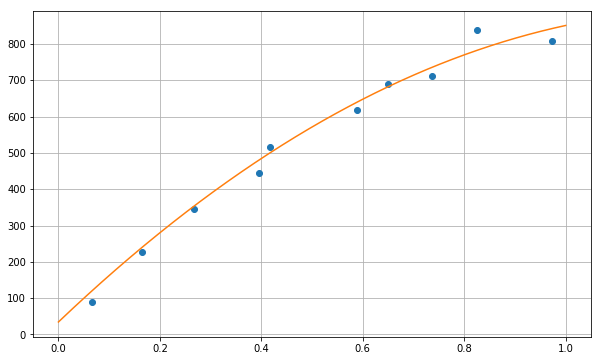

0.6209609478


In [57]:
ref_intensity = 100
#print(data.I)
val = data.loc[data.I == ref_intensity]
print(val)
fig2, ax2 = plt.subplots(figsize=(10,6))
plt.grid()
bins=np.linspace(0.0, 1, val.S.size)
bins2=np.linspace(0.05,0.95,10, endpoint = True)

print(bins2)
att_fit, cov=np.polyfit(val.cos2-np.cos(38*np.pi/180.)**2, val.S, 2, cov=True)
att_fit2, cov2 =sp.optimize.curve_fit(S_i_fit, bins2, val.S)

x=np.linspace(0,1, 1000)
ax2.plot(val.cos2, val.S, lw=0, marker='o')
#ax2.plot(val.cos2, S_i(a,b,c,val.cos2,350), 'r--')
#ax2.plot(x, S_i(a,b,c,x,350),'--g')
ax2.plot(x, S_i_fit(x,att_fit2[0],att_fit2[1],att_fit2[2],att_fit2[3]))
cos_ref=np.cos(38.*np.pi/180.)**2
#ax2.set_yscale('log')

plt.show()
print(cos_ref)

In [58]:
#print(att_fit2)
print(att_fit2, cov2)
print(np.sqrt(np.diag(cov2)))

[-22.30455468  29.97436191  28.70517291  23.09311058] [[  1.88906768e+14  -2.53865606e+14  -2.43116309e+14   1.95711975e+14]
 [ -2.53865606e+14   3.41161656e+14   3.26716029e+14  -2.63010899e+14]
 [ -2.43116309e+14   3.26716029e+14   3.12882066e+14  -2.51874369e+14]
 [  1.95711975e+14  -2.63010899e+14  -2.51874369e+14   2.02762333e+14]]
[ 13744335.85448836  18470561.86801707  17688472.68252452
  14239463.92676943]


In [69]:
#I_resampled=np.random.choice(data.I, 5, replace=False)
#print(I_resampled)

for i in range(0,100):
    

I_new=data.sample(5)
print(I_new)
bins3=np.linspace(0.05,0.95,5, endpoint = True)
att_fit3, cov3 =sp.optimize.curve_fit(S_i_fit, bins3, I_new.S)

                 E       S_ref      cos2           S        th        lgE  \
4714  1.194508e+15  366.711231  0.228380  170.543610  1.072544  15.077189   
8127  1.343632e+15  404.482997  0.797684  455.899740  0.466537  15.128280   
4889  1.711990e+15  494.976260  0.698496  526.883243  0.581279  15.233501   
9641  1.339602e+15  403.471837  0.834475  461.856123  0.419000  15.126976   
1662  1.393436e+15  416.939065  0.728768  452.771377  0.547787  15.144087   

           lgS   lgS_ref    I  
4714  2.231835  2.564324  754  
8127  2.658869  2.606900  457  
4889  2.721714  2.694584  230  
9641  2.664507  2.605813  477  
1662  2.655879  2.620073  471  


In [22]:
#gaussian smearing (10-15%)
sigma=np.sqrt(0.1)
N=len(val.S)
gauss=np.zeros(N)

print(np.random.normal(val.S, sigma))
def gauss_distrib(mu, sigma):
    for i in range(0,N):
        m=mu[i]
        gauss[i]=np.random.normal(m,sigma)
    return gauss
print(gauss_distrib(val.S, sigma))

[  32.99596068  123.80736846  186.27045495  251.47488279  299.34323555
  350.56360367  375.52284279  422.91590647  430.04962878  447.89386036]


KeyError: 0

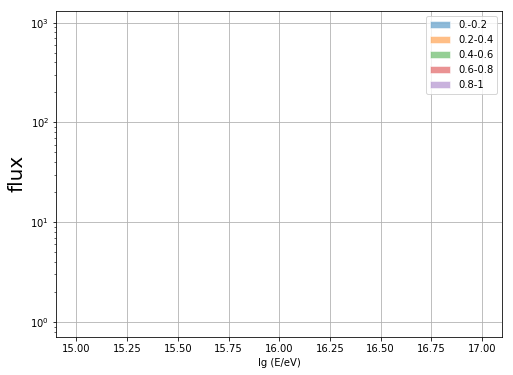

In [7]:
fig2, ax2 = plt.subplots(figsize=(8,6))
plt.grid()
bins2=np.linspace(15, 17, 20)

sel_data = data.loc[data.cos2>0.]
sel_data = sel_data.loc[sel_data.cos2<0.2]
ax2.hist(sel_data.lgE,bins = bins2, normed = False, alpha=0.5,label="0.-0.2", ec='white')

sel_data = data.loc[data.cos2>0.2]
sel_data = sel_data.loc[sel_data.cos2<0.4]
#n4, bins5, patches = ax2.hist(data.lgE,bins = 100, normed = False, label="Histogram", ec='white')
ax2.hist(sel_data.lgE,bins = bins2, normed = False, alpha=0.5,label="0.2-0.4", ec='white')


sel_data= data.loc[data.cos2>0.4]
sel_data=sel_data.loc[sel_data.cos2<0.6]
ax2.hist(sel_data.lgE,bins = bins2, normed = False, alpha=0.5,label="0.4-0.6", ec='white')

sel_data = data.loc[data.cos2>0.6]
sel_data = sel_data.loc[sel_data.cos2<0.8]
ax2.hist(sel_data.lgE,bins = bins2, normed = False, alpha=0.5,label="0.6-0.8", ec='white')


sel_data = data.loc[data.cos2>0.8]
sel_data = sel_data.loc[sel_data.cos2<1.]
ax2.hist(sel_data.lgE,bins = bins2, normed = False, alpha=0.5,label="0.8-1", ec='white')

ax2.set_xlabel("lg (E/eV)")
ax2.set_ylabel("flux", fontsize=20)
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.legend()
plt.show()

In [ ]:
fig2, ax2 = plt.subplots(figsize=(16,10))
#plt.grid()
bins=np.linspace(2.5, 4, 50)

#sel_data = data.loc[data.cos2>0.]
#sel_data = sel_data.loc[sel_data.cos2<0.2]
#ax2.hist(sel_data.lgS,bins = bins, normed = False, alpha=0.5,label="0.-0.2", ec='white')

sel_data = data.loc[data.cos2>0.2]
sel_data = sel_data.loc[sel_data.cos2<0.4]
#n4, bins5, patches = ax2.hist(data.lgE,bins = 100, normed = False, label="Histogram", ec='white')
ax2.hist(sel_data.lgS,bins = bins, normed = False, alpha=0.5,label="0.2-0.4", ec='white')


sel_data= data.loc[data.cos2>0.4]
sel_data=sel_data.loc[sel_data.cos2<0.6]
ax2.hist(sel_data.lgS,bins = bins, normed = False, alpha=0.5,label="0.4-0.6", ec='white')

sel_data = data.loc[data.cos2>0.6]
sel_data = sel_data.loc[sel_data.cos2<0.8]
ax2.hist(sel_data.lgS,bins = bins, normed = False, alpha=0.5,label="0.6-0.8", ec='white')


sel_data = data.loc[data.cos2>0.8]
sel_data = sel_data.loc[sel_data.cos2<1.]
ax2.hist(sel_data.lgS,bins = bins, normed = False, alpha=0.5,label="0.8-1", ec='white')

ax2.set_xlabel("lg (E/eV)")
ax2.set_ylabel("flux", fontsize=20)
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.legend()
plt.show()

In [ ]:
def fit_powerlow(x, a, b):
    return a*(10**(x-15))**b
n= n[np.where(n>10)]

bins2=bins[np.where(n>10)]
from scipy.optimize import curve_fit

pars, cov = curve_fit(fit_powerlow, bins2, n , p0=[1000, 1.5])
print(pars)

fig2, ax2 = plt.subplots(figsize=(8,6))
plt.grid()
ax2.plot(bins2, n)
ax2.plot(bins2, fit_powerlow(bins2, *pars), lw=4, label="Fit_powerlow")
ax2.set_xlabel("log10(E/eV)-18")
ax2.set_ylabel("flux", fontsize=20)
ax2.set_yscale('log')
ax2.legend()
plt.show()

In [ ]:
def fit_Si(x, a, gamma):
     return a*(10**(x-2.5))**(gamma)

n2=n2[np.where(n2>0)]
bins3=bins3[np.where(n2>0)]
pars2, cov2 = curve_fit(fit_Si, bins3, n2 , p0=[100, -1.2])
print(pars2, cov2)

fig2, ax2 = plt.subplots(figsize=(8,6))
plt.grid()
n2, bins3, patches = ax2.hist(np.log10(S_i_ref),bins = 100, normed = False, label="Histogram", ec='white') #plot the data in a histogram with 100 bins

ax2.plot(bins3, fit_Si(bins3, *pars2) , lw=4, label="Fit_Si")
ax2.set_xlabel("X")
ax2.set_ylabel("flux", fontsize=20)
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.legend()
plt.show()

In [ ]:
fig2, ax2 = plt.subplots(figsize=(8,6))
plt.grid()
ax2.hist(data.cos2, bins=10)
ax2.legend()
plt.show()